In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pyhrv
import scipy.io as sio
import biosppy
import pyhrv.tools as tools
import matplotlib as mpl
import seaborn as sns


# CinC 2017

## Poincare

In [49]:
labels = ['Normal', 'AF', 'Other', 'Noisy']

In [50]:
data_dir = '/home/huypham/Projects/ecg/dataset/cinc2017/raw/training'

In [51]:
df = pd.read_csv('/home/huypham/Projects/ecg/dataset/cinc2017/processed/y_train.csv')

In [52]:
df.head()

,idx,N,A,O,~
0,A06/A06486,1,0,0,0
1,A02/A02603,1,0,0,0
2,A08/A08091,1,0,0,0
3,A05/A05958,1,0,0,0
4,A00/A00988,0,0,0,1


In [53]:
n = df[df['N'] == 1].idx.to_list()
a = df[df['A'] == 1].idx.to_list()
o = df[df['O'] == 1].idx.to_list()
nz = df[df['~'] == 1].idx.to_list()

In [54]:
files = [
    n[1],
    a[1],
    o[0],
    nz[0],
]
files = [os.path.join(data_dir, f'{i}.mat') for i in files]

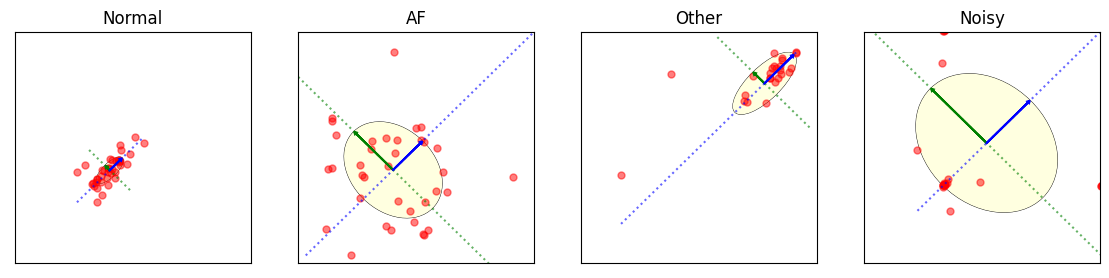

In [55]:
fig, axs = plt.subplots(1, 4, figsize=(14, 3))
# axs = [i for sublist in axs for i in sublist]

for ax, fp, lbl in zip(axs, files, labels):
    ax.set_xlim([100, 400])
    ax.set_ylim([100, 400])
    # ax.set_axis_off()
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title(lbl)

    data = sio.loadmat(fp)['val'].squeeze()
    data = np.nan_to_num(data)

    _, rpeaks = biosppy.signals.ecg.ecg(data, sampling_rate=300, show=False)[1:3]
    nni = tools.nn_intervals(rpeaks)
    
    nn = pyhrv.utils.check_input(nni, rpeaks)

    # Prepare Poincaré data
    x1 = np.asarray(nn[:-1])
    x2 = np.asarray(nn[1:])

    # SD1 & SD2 Computation
    sd1 = np.std(np.subtract(x1, x2) / np.sqrt(2))
    sd2 = np.std(np.add(x1, x2) / np.sqrt(2))

    # Area of ellipse
    area = np.pi * sd1 * sd2

    nn_mean = np.mean(nn)

    # Ellipse
    ellipse_ = mpl.patches.Ellipse((nn_mean, nn_mean), sd1 * 2, sd2 * 2, angle=-45, fc='k', zorder=1)
    ax.add_artist(ellipse_)
    ellipse_ = mpl.patches.Ellipse((nn_mean, nn_mean), sd1 * 2 - 1, sd2 * 2 - 1, angle=-45, fc='lightyellow', zorder=1)
    ax.add_artist(ellipse_)

    # Arrow
    arrow_head_size = 3
    na = 4
    a1 = ax.arrow(
        nn_mean, nn_mean, (-sd1 + na) * np.cos(np.deg2rad(45)), (sd1 - na) * np.sin(np.deg2rad(45)),
        head_width=arrow_head_size, head_length=arrow_head_size, fc='g', ec='g', zorder=4, linewidth=1.5)
    a2 = ax.arrow(
        nn_mean, nn_mean, (sd2 - na) * np.cos(np.deg2rad(45)), (sd2 - na) * np.sin(np.deg2rad(45)),
        head_width=arrow_head_size, head_length=arrow_head_size, fc='b', ec='b', zorder=4, linewidth=1.5)
    a3 = mpl.patches.Patch(facecolor='white', alpha=0.0)
    a4 = mpl.patches.Patch(facecolor='white', alpha=0.0)
    ax.add_line(mpl.lines.Line2D(
        (min(nn), max(nn)),
        (min(nn), max(nn)),
        c='b', ls=':', alpha=0.6))
    ax.add_line(mpl.lines.Line2D(
        (nn_mean - sd1 * np.cos(np.deg2rad(45)) * na, nn_mean + sd1 * np.cos(np.deg2rad(45)) * na),
        (nn_mean + sd1 * np.sin(np.deg2rad(45)) * na, nn_mean - sd1 * np.sin(np.deg2rad(45)) * na),
        c='g', ls=':', alpha=0.6))

    # ax.plot(x1, x2, markersize=2)
    ax.plot(x1, x2, 'r%s' % 'o', markersize=5, alpha=0.5, zorder=1)

plt.savefig('cinc2017_classes.png', bbox_inches='tight')

## Labels distribution

In [56]:
train_df = pd.read_csv('/home/huypham/Projects/ecg/dataset/cinc2017/processed/y_train.csv')
val_df = pd.read_csv('/home/huypham/Projects/ecg/dataset/cinc2017/processed/y_val.csv')
test_df = pd.read_csv('/home/huypham/Projects/ecg/dataset/cinc2017/processed/y_test.csv')

In [57]:
df_1 = train_df.drop(columns=['idx']).sum()
df_2 = val_df.drop(columns=['idx']).sum()
df_3 = test_df.drop(columns=['idx']).sum()

In [58]:
classes_2017 = pd.concat([df_1, df_2, df_3], axis=1)
classes_2017.columns = ['Train', 'Validation', 'Test']
classes_2017.index = labels
classes_2017 = classes_2017.divide(classes_2017.sum(axis=0), axis=1) * 100
classes_2017 = classes_2017.reset_index()
classes_2017

,index,Train,Validation,Test
0,Normal,59.323690,58.440797,61.195780
1,AF,9.108679,8.909730,8.206331
2,Other,28.381548,28.722157,27.725674
3,Noisy,3.186083,3.927315,2.872216


In [59]:
df = pd.melt(classes_2017, id_vars=['index'])
df

,index,variable,value
0,Normal,Train,59.323690
1,AF,Train,9.108679
2,Other,Train,28.381548
3,Noisy,Train,3.186083
4,Normal,Validation,58.440797
5,AF,Validation,8.909730
6,Other,Validation,28.722157
7,Noisy,Validation,3.927315
8,Normal,Test,61.195780
9,AF,Test,8.206331


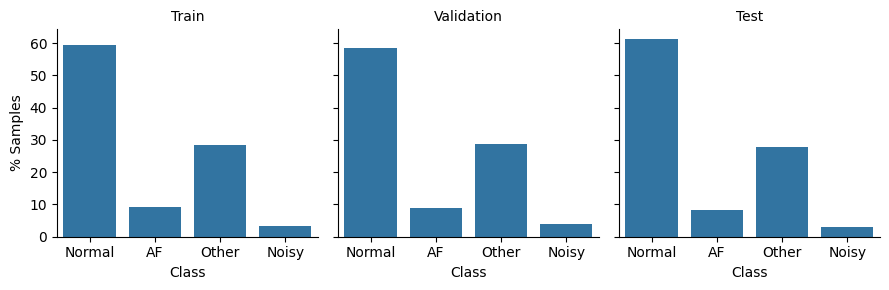

In [61]:
# sns.barplot(data=df, x='variable', y='value', hue='index', palette="muted", facet_kws=dict(margin_titles=True))
g = sns.FacetGrid(df, col='variable')
g.map_dataframe(sns.barplot, x='index', y='value')
g.set_titles("{col_name}")
g.set_axis_labels(x_var="Class", y_var="% Samples")
g.savefig('cinc2017_classes_dist.pdf')

# CinC 2020

In [25]:
import sys
sys.path.append('..')
# from preprocess.cinc2020 import load_mat, load_header_file

def load_mat(fp):
    sample = sio.loadmat(fp)['val']
    return sample

def load_header_file(header_file):
    with open(header_file, 'r') as f:
        header = f.readlines()
    header = [line.strip('\n') for line in header]
    return header

In [26]:
classes = "AF,AFL,Brady,CRBBB,IAVB,IRBBB,LAD,LAnFB,LBBB,LPR,LQRSV,LQT,NSIVCB,Other,PAC,PR,PVC,QAb,RAD,RBBB,SA,SB,SNR,STach,SVPB,TAb,TInv,VPB".split(',')
len(classes)

28

In [27]:
data_dir = "/home/huypham/Projects/ecg/dataset/cinc2020/raw/"

In [28]:
df = pd.read_csv('/home/huypham/Projects/ecg/dataset/cinc2020/processed/y_train.csv')

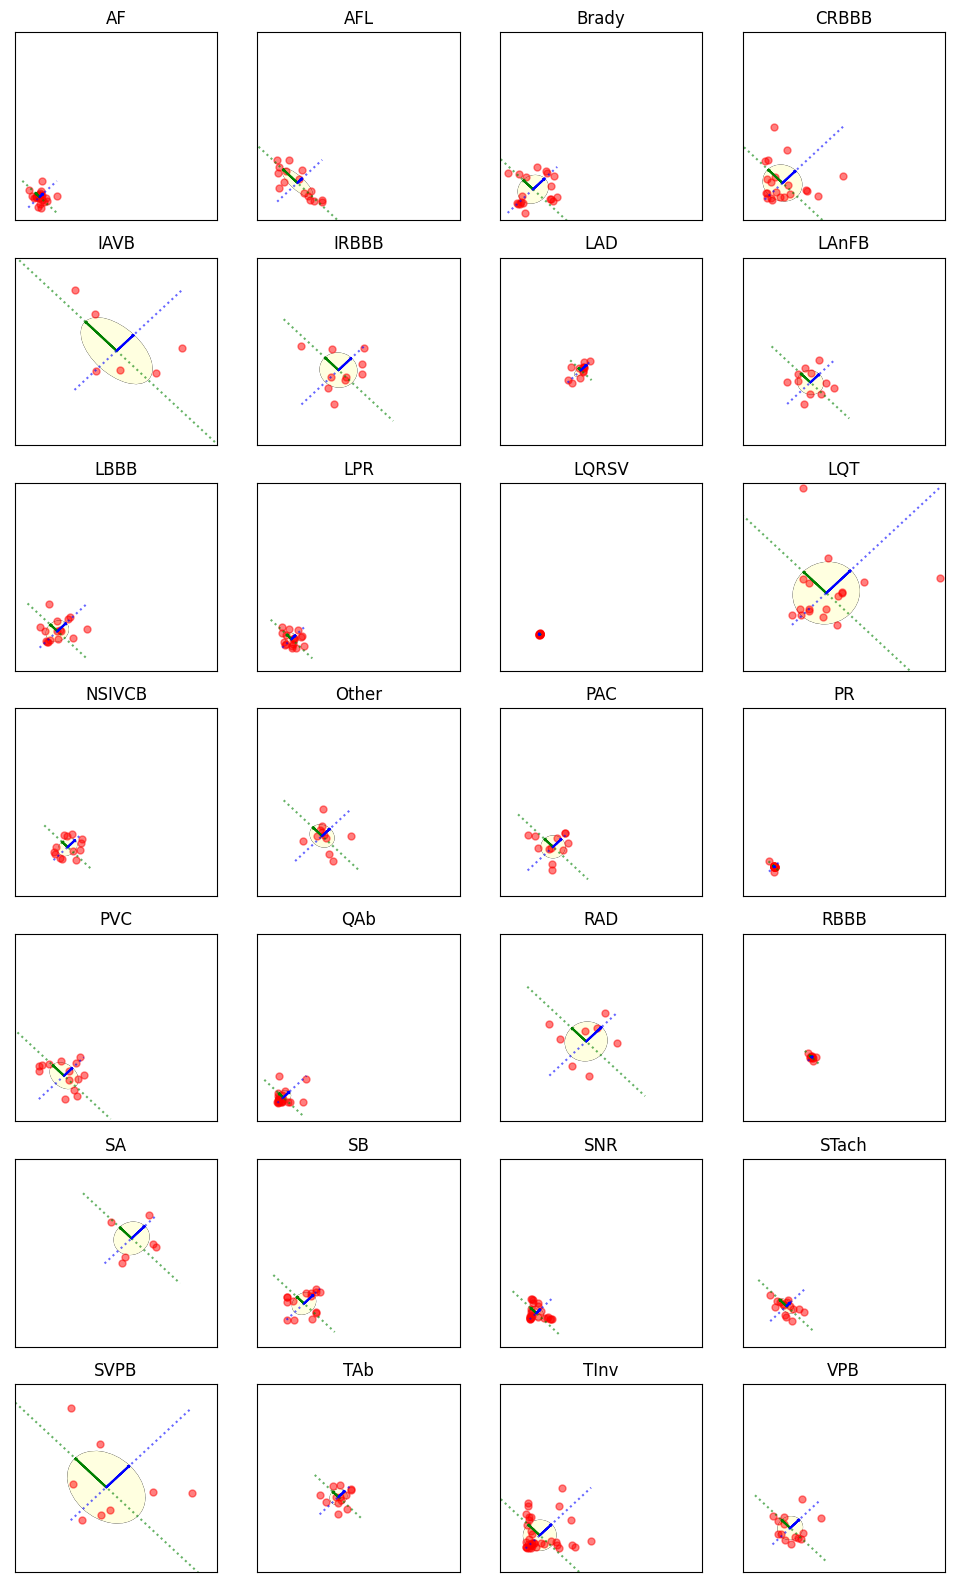

In [29]:
fig, axs = plt.subplots(7, 4, figsize=(12, 20))
axs = [i for sublist in axs for i in sublist]
for lbl, ax in zip(classes, axs):
    fp = df[df['AF'] == 1].idx.sample(n=1).tolist()[0]
    fp = os.path.join(data_dir, fp)

    header_file = fp.replace('.mat', '.hea')
    mat_file = fp.replace('.hea', '.mat')

    sample = load_mat(mat_file)[0].flatten()
    headers = load_header_file(header_file)
    sampling_rate = int(headers[0].split(' ')[2])

    ax.set_xlim([100, 900])
    ax.set_ylim([100, 900])
    # ax.set_axis_off()
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title(lbl)

    _, rpeaks = biosppy.signals.ecg.ecg(sample, sampling_rate=sampling_rate, show=False)[1:3]
    nni = tools.nn_intervals(rpeaks)
    
    nn = pyhrv.utils.check_input(nni, rpeaks)

    # Prepare Poincaré data
    x1 = np.asarray(nn[:-1])
    x2 = np.asarray(nn[1:])

    # SD1 & SD2 Computation
    sd1 = np.std(np.subtract(x1, x2) / np.sqrt(2))
    sd2 = np.std(np.add(x1, x2) / np.sqrt(2))

    # Area of ellipse
    area = np.pi * sd1 * sd2

    nn_mean = np.mean(nn)

    # Ellipse
    ellipse_ = mpl.patches.Ellipse((nn_mean, nn_mean), sd1 * 2, sd2 * 2, angle=-45, fc='k', zorder=1)
    ax.add_artist(ellipse_)
    ellipse_ = mpl.patches.Ellipse((nn_mean, nn_mean), sd1 * 2 - 1, sd2 * 2 - 1, angle=-45, fc='lightyellow', zorder=1)
    ax.add_artist(ellipse_)

    # Arrow
    arrow_head_size = 3
    na = 4
    a1 = ax.arrow(
        nn_mean, nn_mean, (-sd1 + na) * np.cos(np.deg2rad(45)), (sd1 - na) * np.sin(np.deg2rad(45)),
        head_width=arrow_head_size, head_length=arrow_head_size, fc='g', ec='g', zorder=4, linewidth=1.5)
    a2 = ax.arrow(
        nn_mean, nn_mean, (sd2 - na) * np.cos(np.deg2rad(45)), (sd2 - na) * np.sin(np.deg2rad(45)),
        head_width=arrow_head_size, head_length=arrow_head_size, fc='b', ec='b', zorder=4, linewidth=1.5)
    a3 = mpl.patches.Patch(facecolor='white', alpha=0.0)
    a4 = mpl.patches.Patch(facecolor='white', alpha=0.0)
    ax.add_line(mpl.lines.Line2D(
        (min(nn), max(nn)),
        (min(nn), max(nn)),
        c='b', ls=':', alpha=0.6))
    ax.add_line(mpl.lines.Line2D(
        (nn_mean - sd1 * np.cos(np.deg2rad(45)) * na, nn_mean + sd1 * np.cos(np.deg2rad(45)) * na),
        (nn_mean + sd1 * np.sin(np.deg2rad(45)) * na, nn_mean - sd1 * np.sin(np.deg2rad(45)) * na),
        c='g', ls=':', alpha=0.6))

    # ax.plot(x1, x2, markersize=2)
    ax.plot(x1, x2, 'r%s' % 'o', markersize=5, alpha=0.5, zorder=1)

plt.savefig('cinc2020_classes.png', bbox_inches='tight')

In [62]:
train_df = pd.read_csv('/home/huypham/Projects/ecg/dataset/cinc2020/processed/y_train.csv')
val_df = pd.read_csv('/home/huypham/Projects/ecg/dataset/cinc2020/processed/y_val.csv')
test_df = pd.read_csv('/home/huypham/Projects/ecg/dataset/cinc2020/processed/y_test.csv')

In [63]:
df_1 = train_df.drop(columns=['idx']).sum()
df_2 = val_df.drop(columns=['idx']).sum()
df_3 = test_df.drop(columns=['idx']).sum()

In [75]:
classes_2020 = pd.concat([df_1, df_2, df_3], axis=1)
classes_2020.columns = ['Train', 'Validation', 'Test']
classes_2020.index = classes
classes_2020 = classes_2020.divide(classes_2020.sum(axis=0), axis=1) * 100
classes_2020 = classes_2020.reset_index()
classes_2020

In [34]:
df = pd.melt(classes_2020, id_vars=['index'])
df

,index,variable,value
0,AF,Train,4.160645
1,AFL,Train,0.403037
2,Brady,Train,0.366397
3,CRBBB,Train,0.834572
4,IAVB,Train,2.961711
...,...,...,...
79,STach,Test,3.208556
80,SVPB,Test,0.258160
81,TAb,Test,5.642633
82,TInv,Test,1.432172


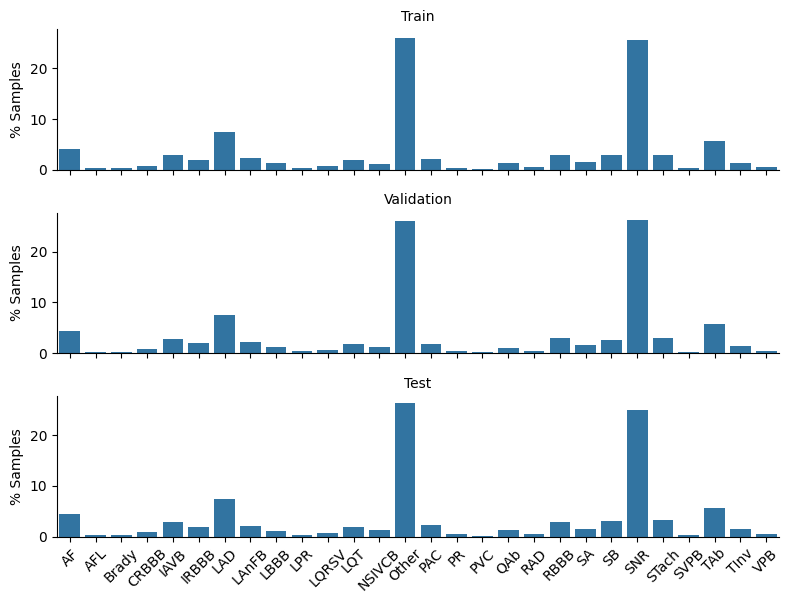

In [48]:
# sns.barplot(data=df, x='variable', y='value', hue='index', palette="muted", facet_kws=dict(margin_titles=True))
g = sns.FacetGrid(df, col='variable', col_wrap=1, aspect=4, height=2)
g.map_dataframe(sns.barplot, x='index', y='value')
g.set_titles("{col_name}")
g.set_axis_labels(x_var="", y_var="% Samples")
# g.set_xticklabels(rotation=30)
plt.xticks(rotation=45);
g.savefig('cinc2020_classes_dist.pdf')

In [73]:
df = pd.concat([train_df, val_df, test_df], axis=0)
df.head()

,idx,AF,AFL,Brady,CRBBB,IAVB,IRBBB,LAD,LAnFB,LBBB,...,RAD,RBBB,SA,SB,SNR,STach,SVPB,TAb,TInv,VPB
0,training/georgia/g8/E07698.hea,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,training/ptb-xl/g21/HR20483.hea,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,training/ptb-xl/g10/HR09674.hea,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,training/ptb-xl/g10/HR09573.hea,0,0,0,0,0,0,1,1,0,...,0,0,0,0,1,0,0,0,0,0
4,training/cpsc_2018/g1/A0653.hea,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [69]:
df['idx'].apply(lambda x: x.str.split('/')[1])

,idx,idx,idx
0,training,training,training
1,ptb-xl,georgia,georgia
2,g21,g6,g2
3,HR20483.hea,E05943.hea,E01917.hea


In [71]:
[i for i in df['idx']]

['idx', 'idx', 'idx']

In [72]:
df['idx']

,idx,idx,idx
0,training/georgia/g8/E07698.hea,training/ptb-xl/g6/HR05085.hea,training/ptb-xl/g5/HR04507.hea
1,training/ptb-xl/g21/HR20483.hea,training/georgia/g6/E05943.hea,training/georgia/g2/E01917.hea
2,training/ptb-xl/g10/HR09674.hea,training/cpsc_2018/g6/A5020.hea,training/ptb-xl/g20/HR19636.hea
3,training/ptb-xl/g10/HR09573.hea,training/cpsc_2018/g1/A0226.hea,training/ptb-xl/g5/HR04522.hea
4,training/cpsc_2018/g1/A0653.hea,training/georgia/g1/E00257.hea,training/ptb-xl/g4/HR03100.hea
...,...,...,...
25855,training/cpsc_2018_extra/g3/Q2496.hea,NaN,NaN
25856,training/ptb-xl/g6/HR05079.hea,NaN,NaN
25857,training/ptb-xl/g21/HR20244.hea,NaN,NaN
25858,training/ptb-xl/g10/HR09693.hea,NaN,NaN
